# THE INSURANCE COMPANY

En este trabajo vamos a realizar un EDA sobre los datos de una aseguradora para predecir qué clientes pueden o no tener una caravana. Para ello utilizaremos datos creados por la empresa holandesa Sentient Machine Research.

## Diccionario
A continuación se muestra una tabla con los datos obtenidos y su descripción

## Importación de librerías a utilizar

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import plotly.express as px
from matplotlib import pyplot as plt
import funciones_auxiliares as f_aux

In [2]:
def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    # Para obtener la correlación de Spearman, sólo cambiar el metodo por 'spearman'

    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    # Compute the correlation matrix
    corr = dataset.corr(method=metodo) 
    # Set self-correlation to zero to avoid distraction
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size_figure)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()
    
    return 0




## Lectura de datos y creación de tablas

Vamos a crear una tabla con los datos del documento **ticdata2000.txt**. Este será el dataset destinado al training del algoritmo. Vamos a añadir los nombres de las columnas ya que no aparecen en el documento de datos y convertirlos a minúsculas.

Llamaremos a esta tabla **data**

In [3]:
data = pd.read_table("../Data/ticdata2000.txt", header=None)

data.columns = ([
    "MOSTYPE", "MAANTHUI", "MGEMOMV", "MGEMLEEF","MOSHOOFD","MGODRK","MGODPR",
    "MGODOV","MGODGE","MRELGE","MRELSA", "MRELOV","MFALLEEN","MFGEKIND",
    "MFWEKIND","MOPLHOOG","MOPLMIDD", "MOPLLAAG", "MBERHOOG", "MBERZELF", 
    "MBERBOER","MBERMIDD", "MBERARBG", "MBERARBO", "MSKA", "MSKB1", "MSKB2",
    "MSKC", "MSKD", "MHHUUR", "MHKOOP", "MAUT1", "MAUT2", "MAUT0", "MZFONDS",
    "MZPART", "MINKM30", "MINK3045", "MINK4575","MINK7512", "MINK123M", 
    "MINKGEM", "MKOOPKLA", "PWAPART", "PWABEDR", "PWALAND", "PPERSAUT", 
    "PBESAUT", "PMOTSCO","PVRAAUT", "PAANHANG", "PTRACTOR", "PWERKT", "PBROM", 
    "PLEVEN", "PPERSONG", "PGEZONG", "PWAOREG", "PBRAND", "PZEILPL", 
    "PPLEZIER", "PFIETS", "PINBOED", "PBYSTAND", "AWAPART", "AWABEDR",
    "AWALAND", "APERSAUT", "ABESAUT", "AMOTSCO", "AVRAAUT", "AAANHANG", 
    "ATRACTOR", "AWERKT", "ABROM", "ALEVEN", "APERSONG","AGEZONG", "AWAOREG", 
    "ABRAND", "AZEILPL", "APLEZIER", "AFIETS", "AINBOED", "ABYSTAND", "CARAVAN" 
    ])
data.columns = data.columns.str.lower()

## Análisis general

**Vamos a eliminar las siguientes columnas:**

- mgodge, mgodov, mgodpr, mgodrk: tienen en cuenta la religion, lo cual no es correcto.
- moshoofd: contiene religion y politica

In [4]:
data = data.drop(["mgodge", "mgodov", "mgodpr", "mgodrk", "moshoofd"], axis=1)

In [5]:
print((data.shape), data.drop_duplicates().shape)
data.drop_duplicates().shape

(5822, 81) (5220, 81)


(5220, 81)

**data** tiene 5822 filas y 79 variables. Tan solo hay 2 duplicadas, por lo que para este análisis vamos a tratarlo como distintos clientes

## Exploración de la variable objetivo

In [6]:
pd_plot_caravans = data['caravan']\
        .value_counts(normalize=True)\
        .mul(100).rename('percent').reset_index()
pd_plot_caravans_conteo = data['caravan'].value_counts().reset_index()
pd_plot_caravans_pc = pd.merge(pd_plot_caravans, pd_plot_caravans_conteo, on=['index'], how='inner')
pd_plot_caravans_pc

index    percent  caravan
0      0  94.022673     5474
1      1   5.977327      348

In [7]:
fig = px.histogram(pd_plot_caravans_pc, x="index", y=['percent'])
fig.show()

Como se puede observar en la tabla y gráfica superior, el 94% de los usuarios registados en los datos proporcionado no tienen una caravana asegurada, mientras que un 6% sí. Por lo tanto esta es una variable no balanceada.

## Análisis de nulos 

Procedemos a observar la existencia de posibles datos nulos

In [8]:
pd_series_null_columns = data.isnull().sum().sort_values(ascending=False)
pd_series_null_rows = data.isnull().sum(axis=1).sort_values(ascending=False)
print(pd_series_null_columns.shape, pd_series_null_rows.shape)

pd_null_columnas = pd.DataFrame(pd_series_null_columns, columns=['nulos_columnas'])     
pd_null_filas = pd.DataFrame(pd_series_null_rows, columns=['nulos_filas'])  
pd_null_filas['target'] = data['caravan'].copy()
pd_null_columnas['porcentaje_columnas'] = pd_null_columnas['nulos_columnas']/data.shape[0]
pd_null_filas['porcentaje_filas']= pd_null_filas['nulos_filas']/data.shape[1]

(81,) (5822,)


In [9]:
data.shape

(5822, 81)

In [10]:
pd_null_columnas

nulos_columnas  porcentaje_columnas
mostype                0                  0.0
ppersaut               0                  0.0
awapart                0                  0.0
pbystand               0                  0.0
pinboed                0                  0.0
...                  ...                  ...
maut1                  0                  0.0
mhkoop                 0                  0.0
mhhuur                 0                  0.0
mskd                   0                  0.0
caravan                0                  0.0

[81 rows x 2 columns]

No tenemos datos nulos por lo que no hace falta filtrar ninguna columna basandonos en este criterio.

## Variables categóricas y numércias

Vamos a tomar como variables numéricas aquellas variables que cuenten el número de propiedades (ya sea casas, o seguros). El resto de variables serán categóricas

In [11]:
list_num_vars = [
    "maanthui", "awapart", "awabedr", "awaland", "apersaut", "abesaut", "amotsco", "avraaut", "aaanhang",
    "atractor", "awerkt", "abrom", "aleven", "apersong", "agezong", "awaoreg", "abrand", "azeilpl","aplezier",
    "afiets", "ainboed", "abystand"
]

list_cat_vars = [
    "mgemomv", "mgemleef","mrelge", "mrelsa", "mrelov", "mfalleen", "mfgekind", "mfwekind", "moplhoog", "moplmidd", 
    "mopllaag", "mberhoog", "mberzelf", "mberboer", "mbermidd", "mberarbg", "mberarbo", "mska", "mskb1", "mskb2", 
    "mskc", "mskd", "mhhuur", "mhkoop", "maut1", "maut2", "maut0", "mzfonds", "mzpart", "minkgem", "minkm30", "mink3045", 
    "mink4575", "mink7512", "mink123m", "mkoopkla", "pwapart", "pwabedr", "pwaland", "ppersaut", "pbesaut", 
    "pmotsco", "pvraaut", "paanhang", "ptractor", "pwerkt", "pbrom", "pleven", "ppersong", "pgezong", "pwaoreg", 
    "pbrand", "pzeilpl",  "pplezier", "pfiets", "pinboed", "pbystand" 
]
"maanthui"

'maanthui'

In [12]:
data[list_cat_vars] = data[list_cat_vars].astype("category") 

In [13]:
data[list_num_vars].head()

maanthui  awapart  awabedr  awaland  apersaut  abesaut  amotsco  avraaut  \
0         1        0        0        0         1        0        0        0   
1         1        2        0        0         0        0        0        0   
2         1        1        0        0         1        0        0        0   
3         1        0        0        0         1        0        0        0   
4         1        0        0        0         0        0        0        0   

   aaanhang  atractor  ...  aleven  apersong  agezong  awaoreg  abrand  \
0         0         0  ...       0         0        0        0       1   
1         0         0  ...       0         0        0        0       1   
2         0         0  ...       0         0        0        0       1   
3         0         0  ...       0         0        0        0       1   
4         0         0  ...       0         0        0        0       1   

   azeilpl  aplezier  afiets  ainboed  abystand  
0        0         0       0        0         0  
1        0         0       0        0         0  
2        0         0       0        0         0  
3        0         0       0        0         0  
4        0         0       0        0         0  

[5 rows x 22 columns]

## Correlación de las variables numércias

A continuación estudiaremos si existe una correlación entre las variables numéricas para poder descartar alguna columna

In [14]:
corr = data[list_num_vars].corr('pearson')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) # below main lower triangle of an array
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.3]

level_0  level_1  correlation
201  atractor  awaland     0.547175
353    abrand  awapart     0.525261
225    awerkt  abesaut     0.379082

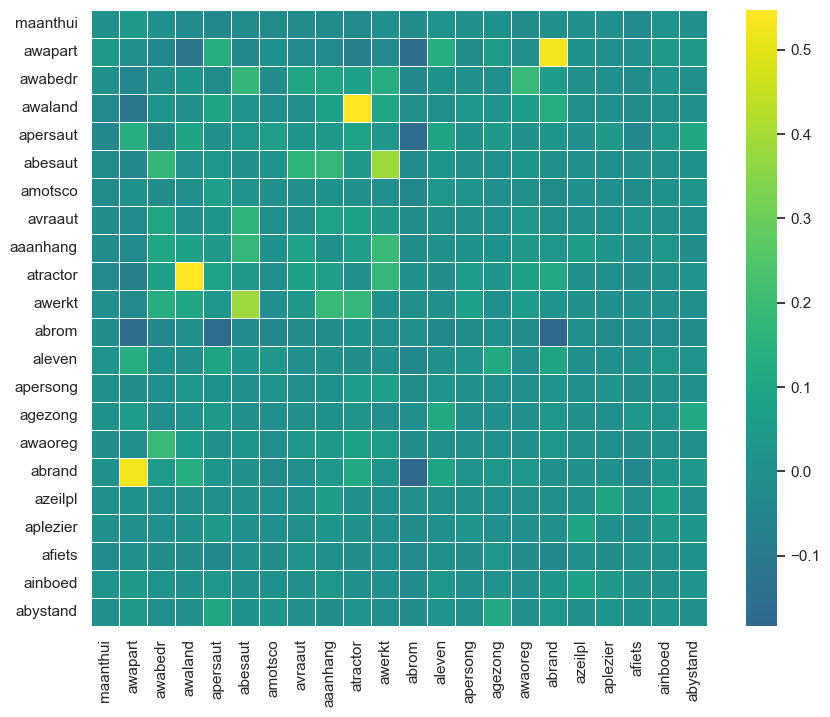

0

In [15]:
f_aux.get_corr_matrix(dataset = data[list_num_vars], 
                metodo='pearson', size_figure=[10,8])

La mayor correlación se produce entre el número de otros seguros privados y el número de seguros agrícolas contatados con otros seguros, pero solo es de 0.547. Por lo tanto no eliminaremos nonguna de las 2 variables.

## Tratamiento de outliers

Ahora realizaremos unos gráficos de caja para poder observar la existencia de outliers en las variables. 

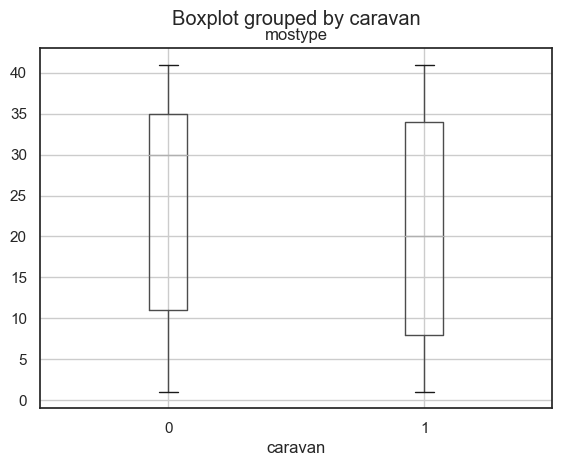

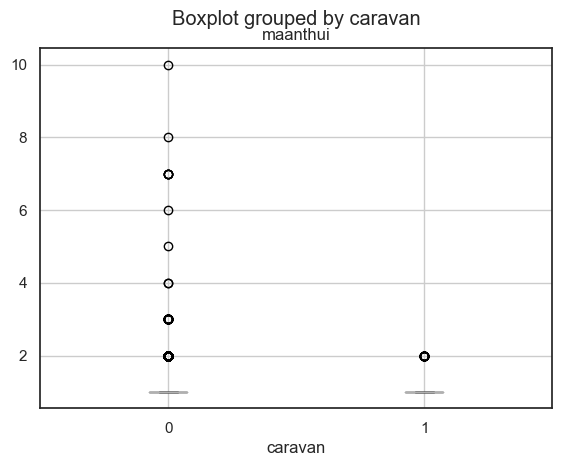

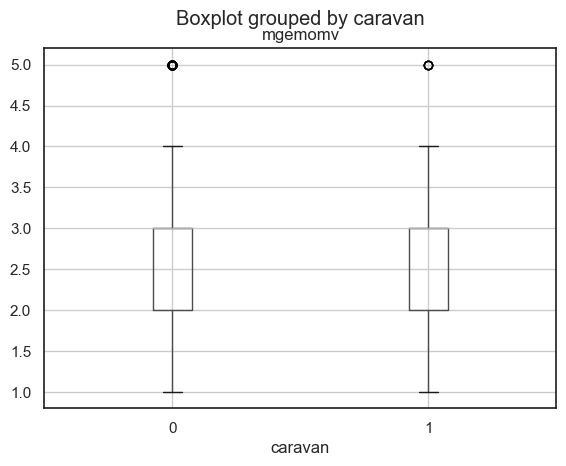

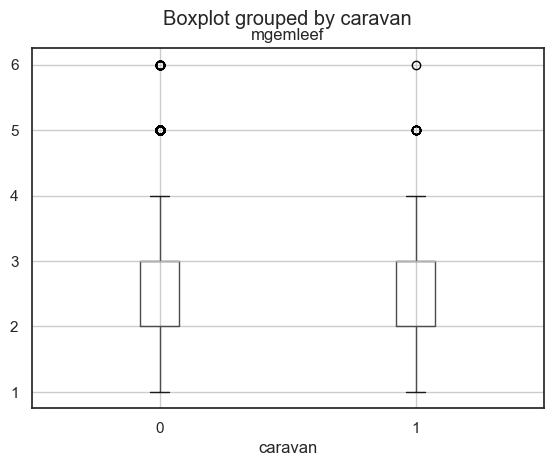

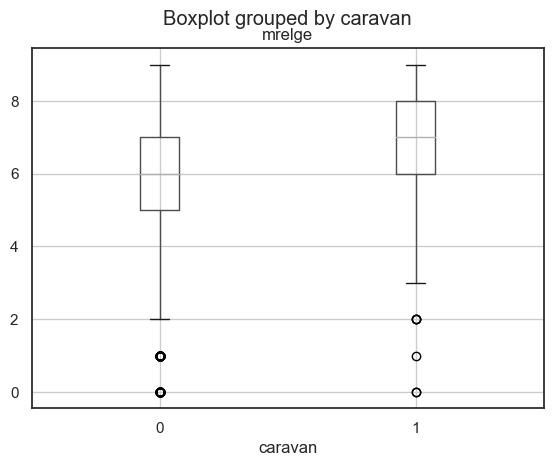

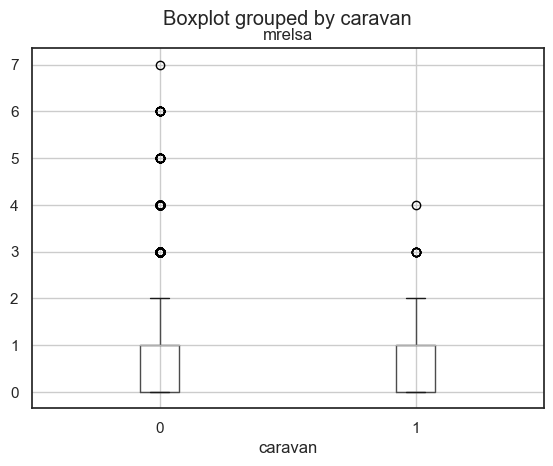

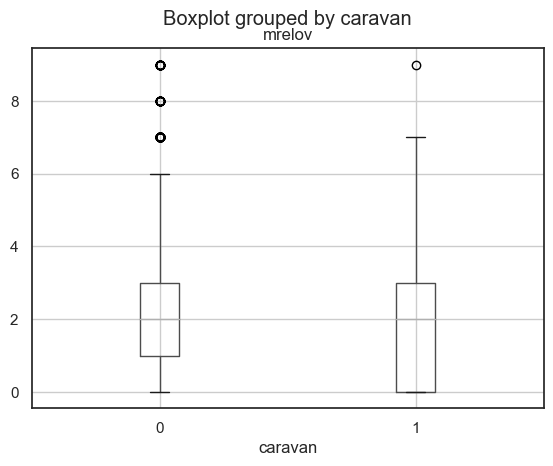

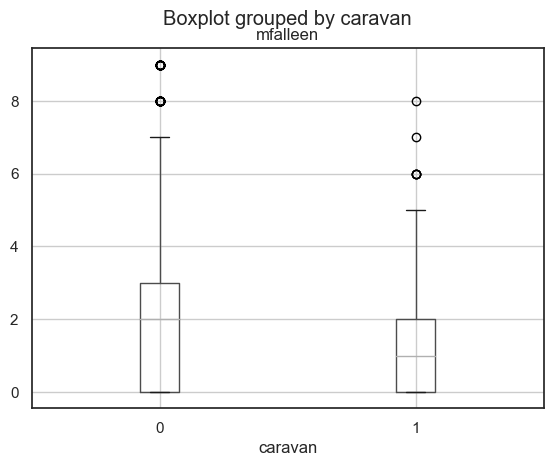

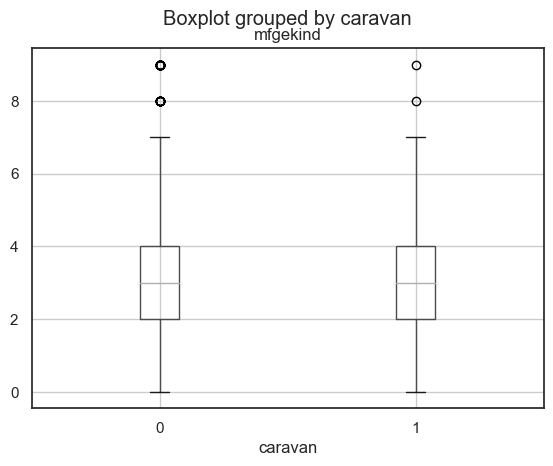

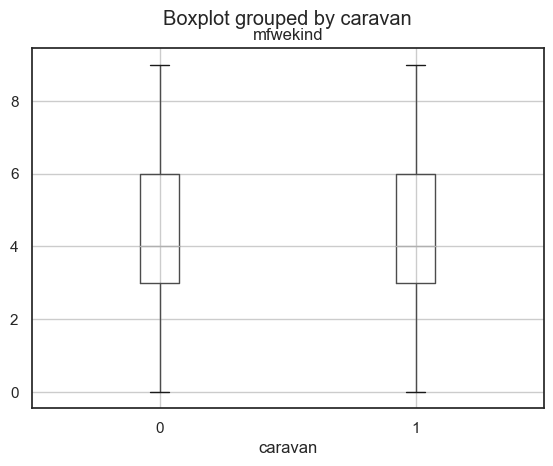

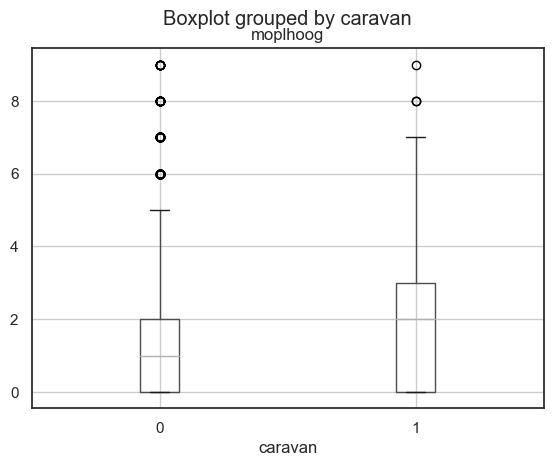

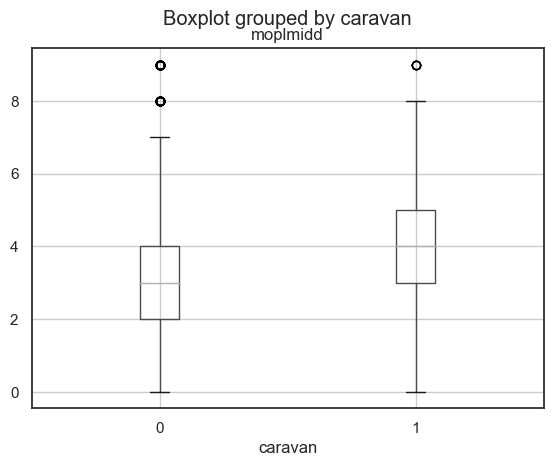

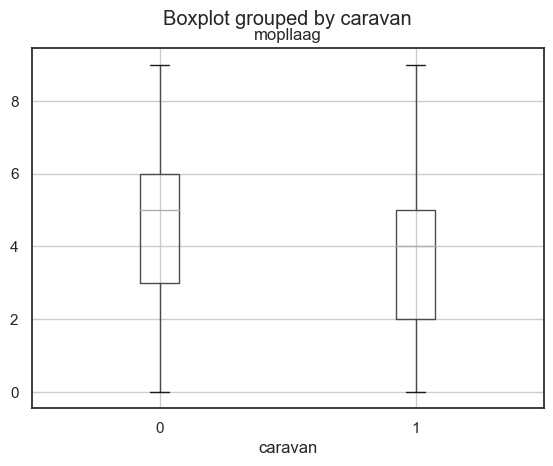

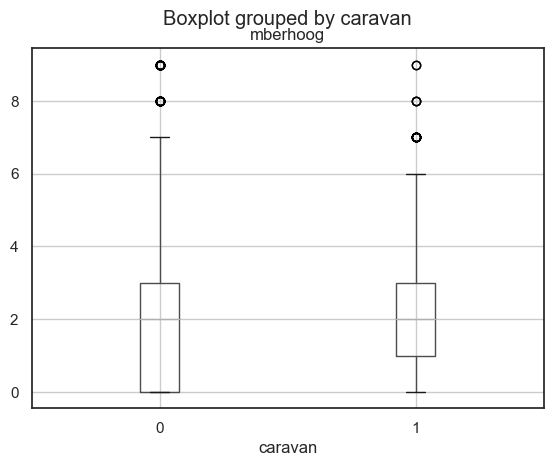

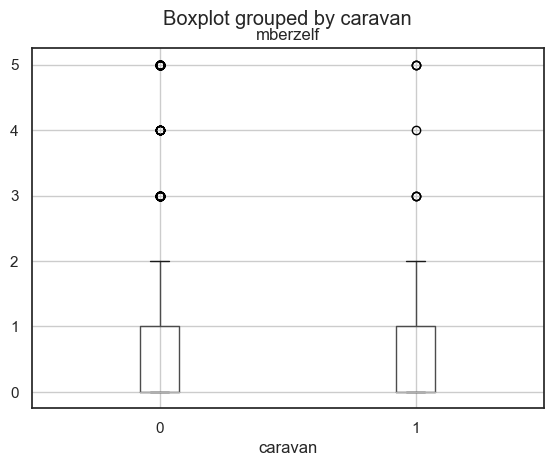

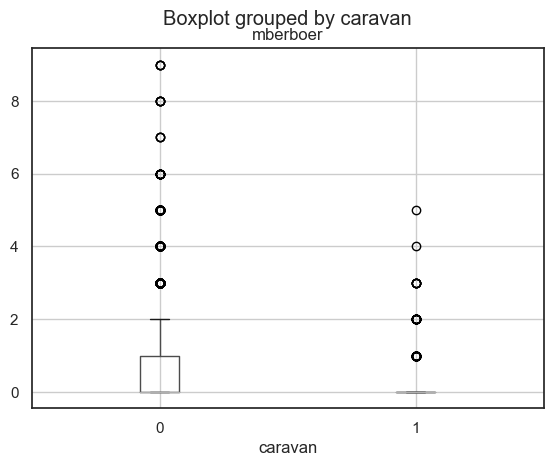

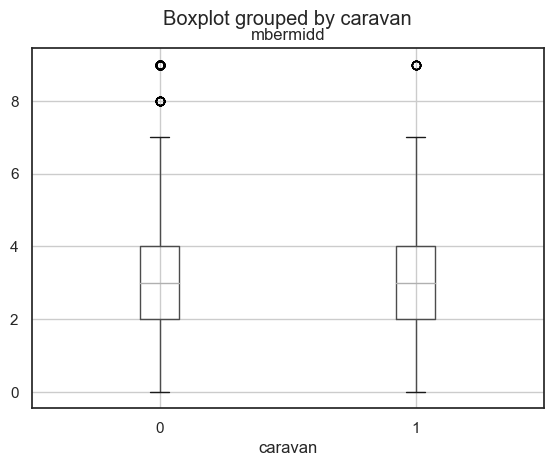

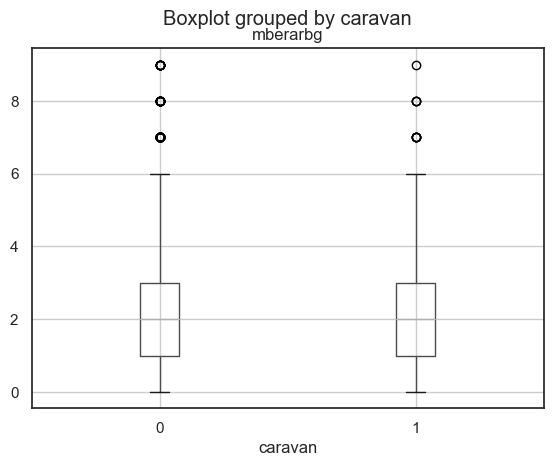

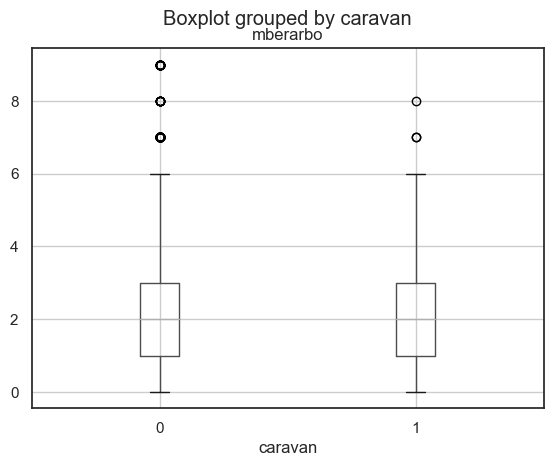

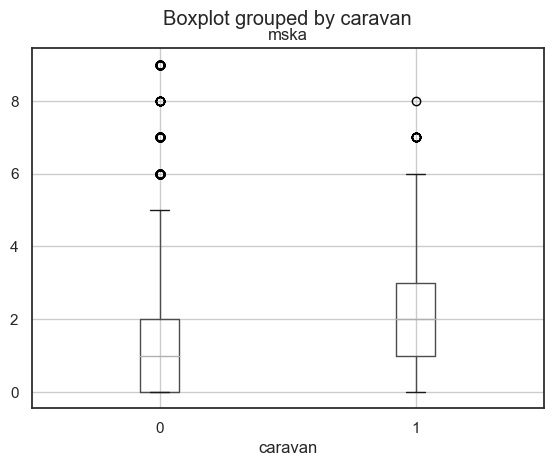

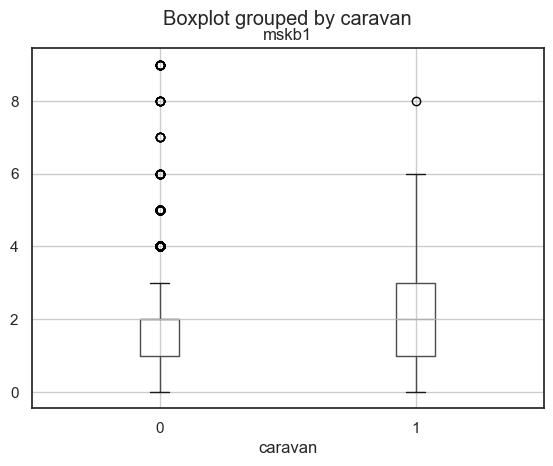

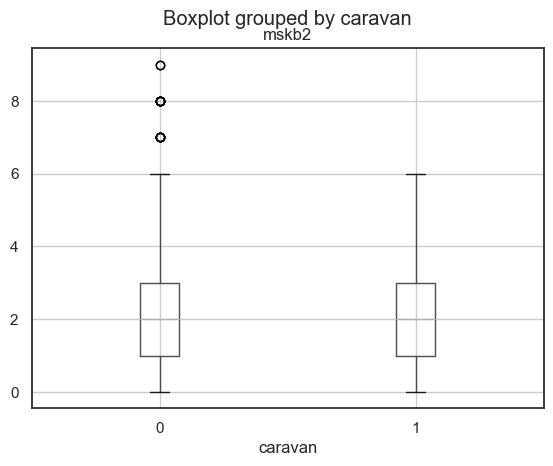

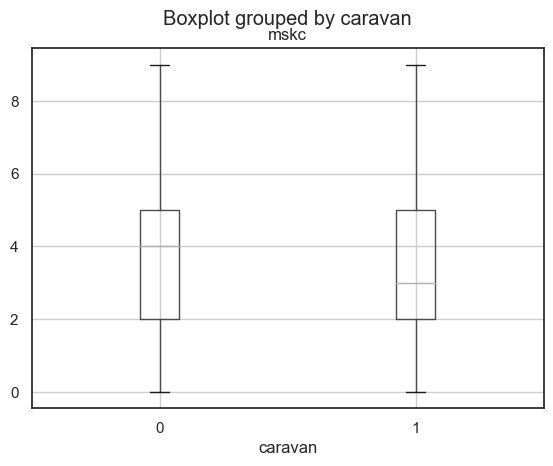

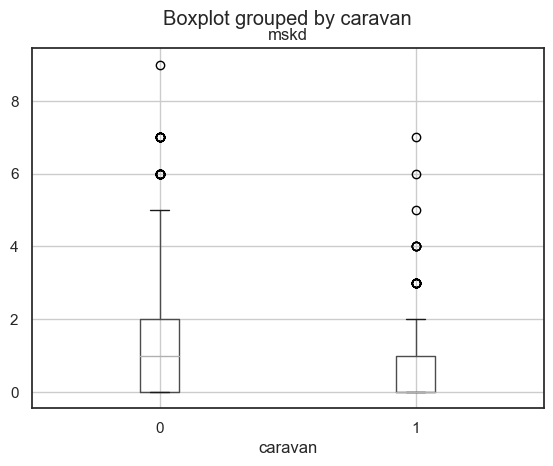

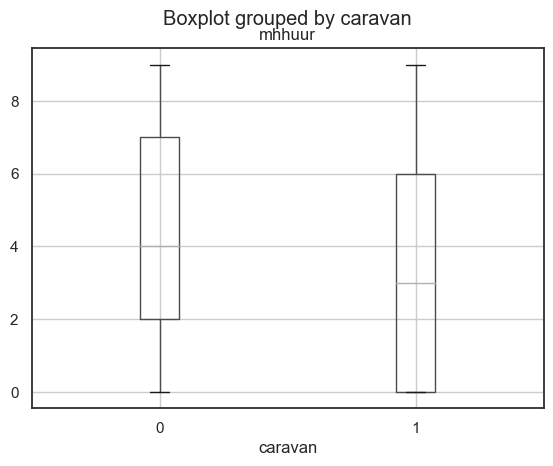

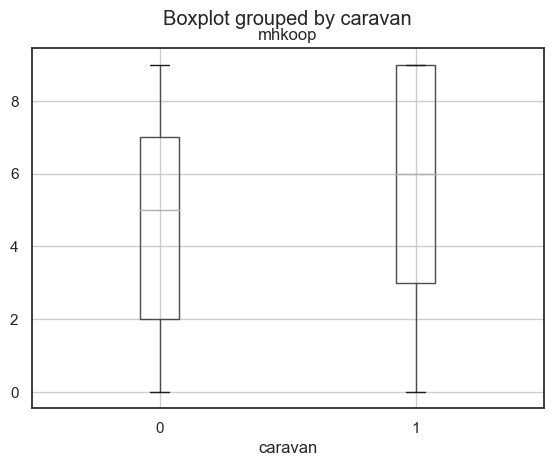

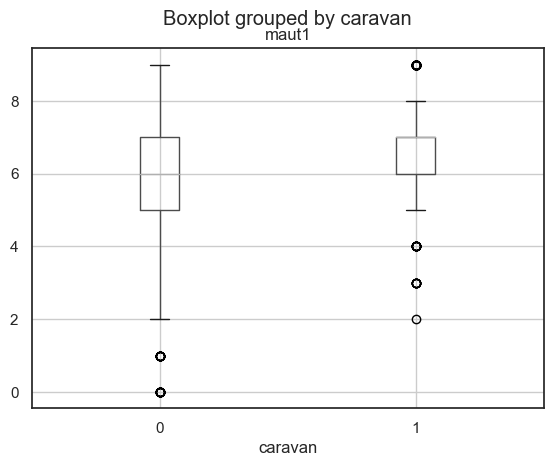

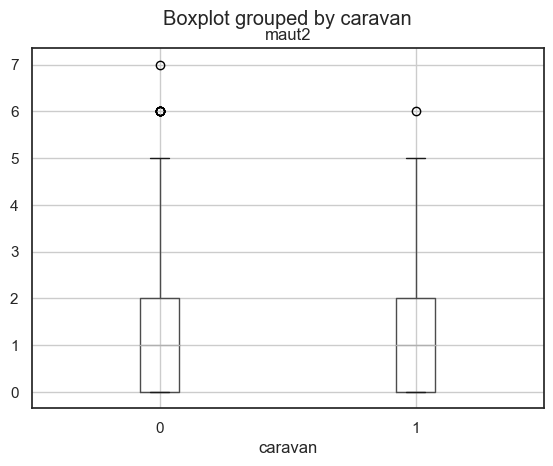

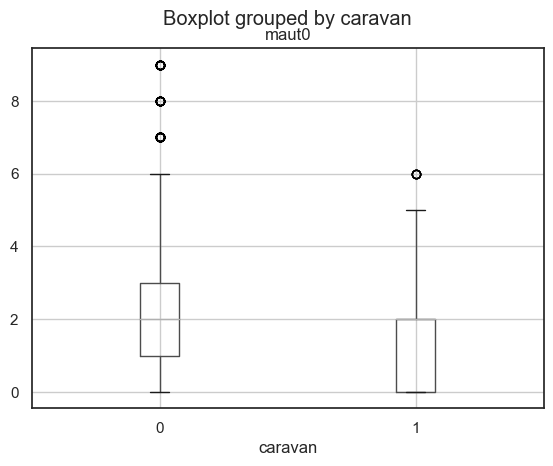

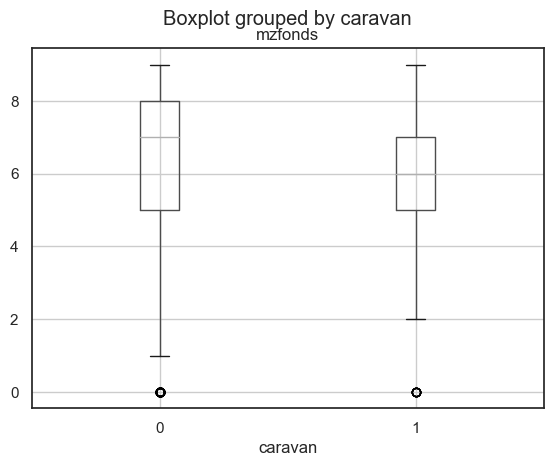

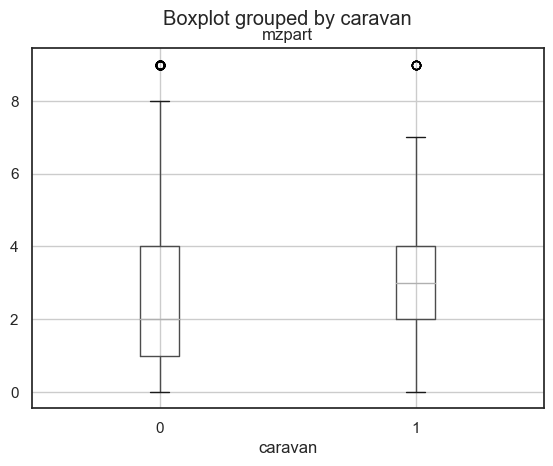

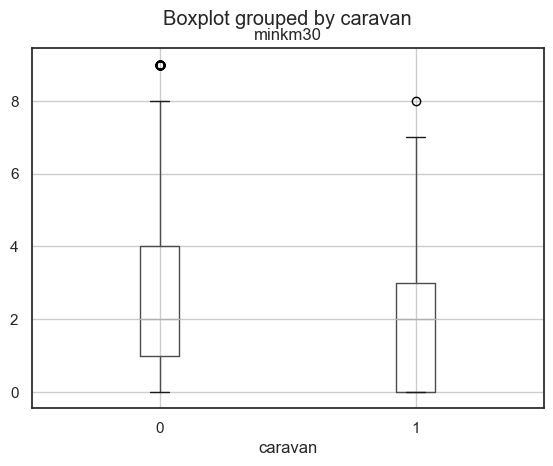

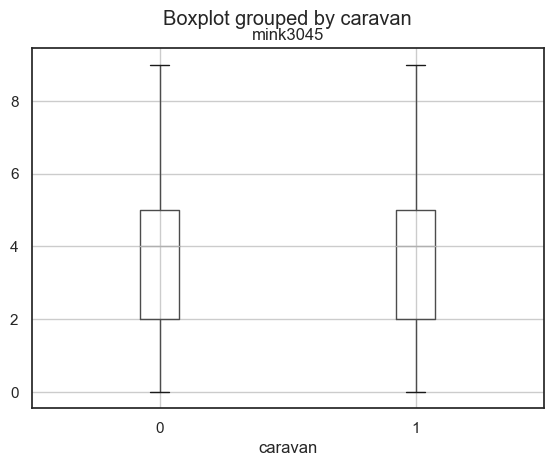

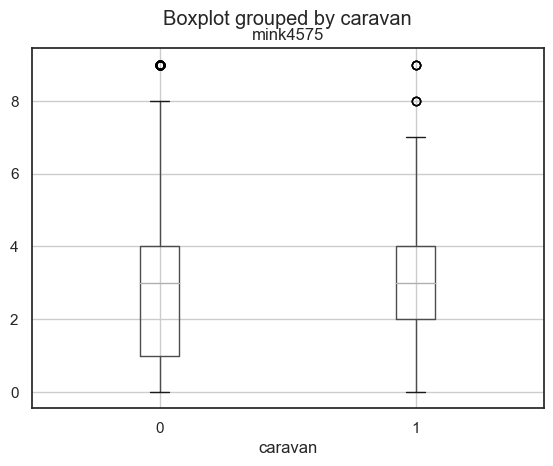

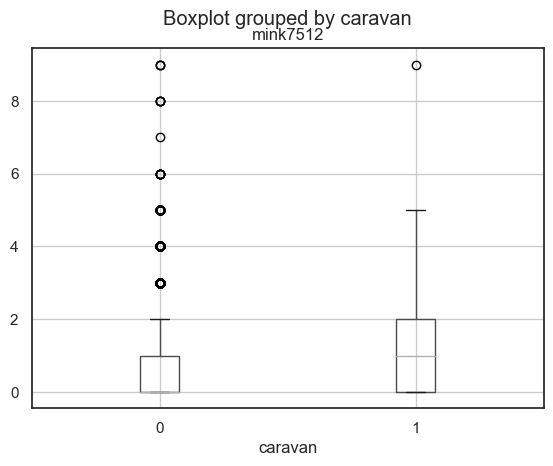

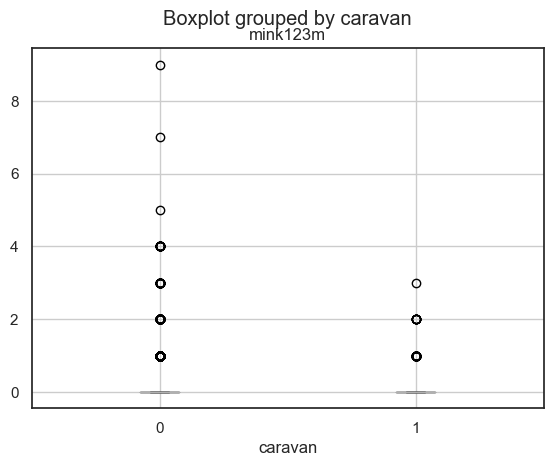

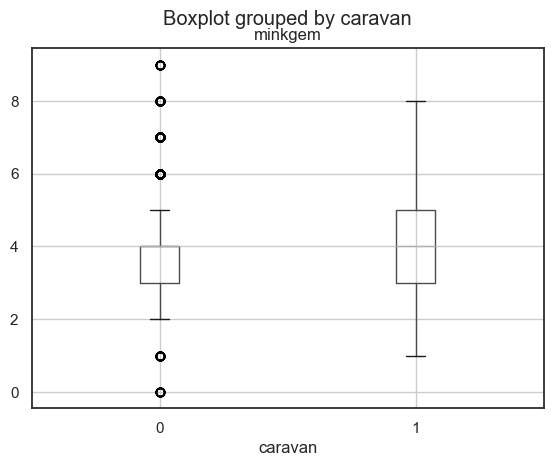

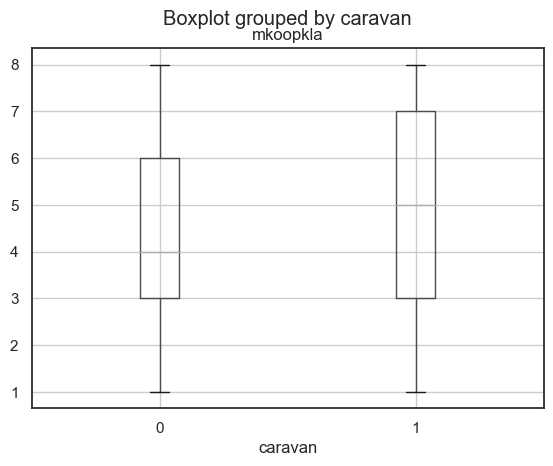

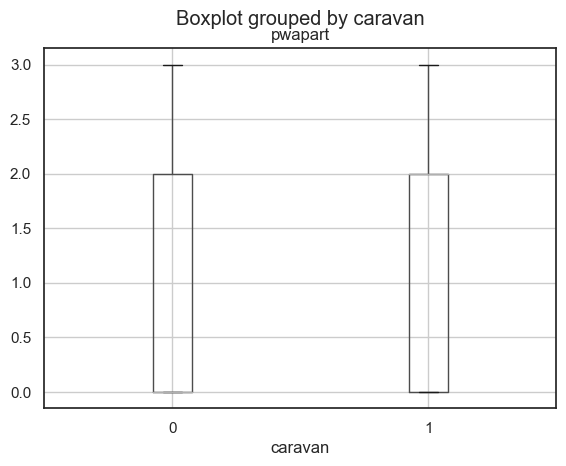

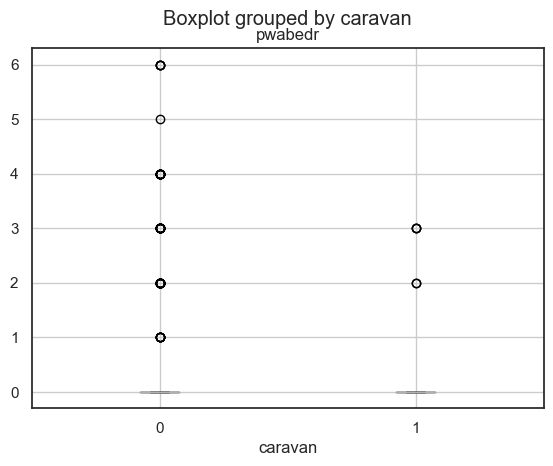

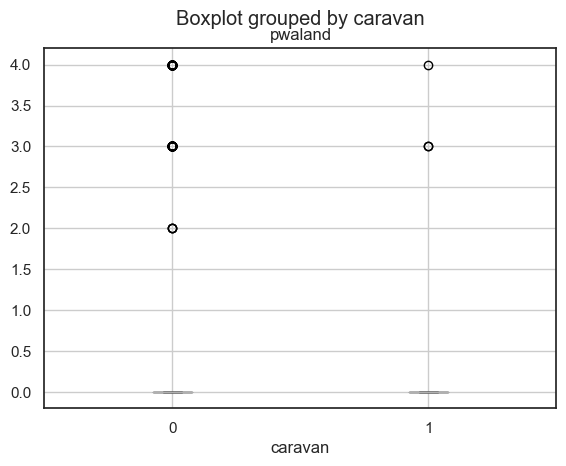

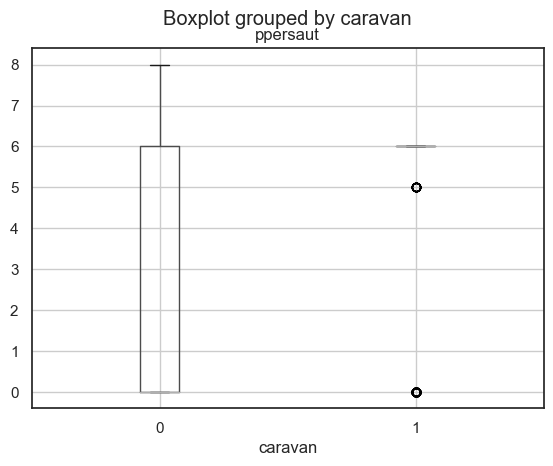

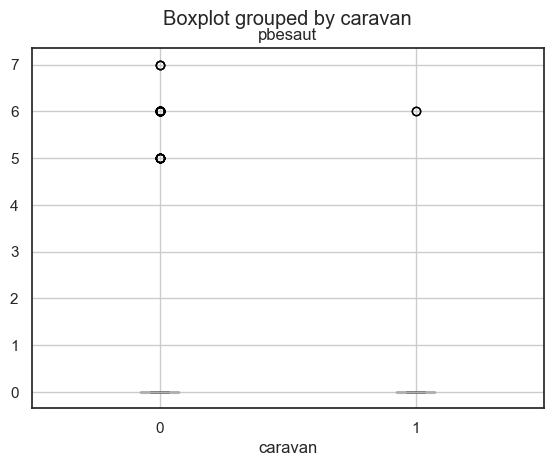

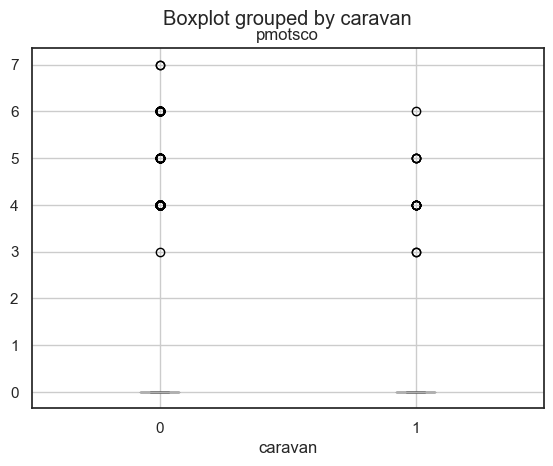

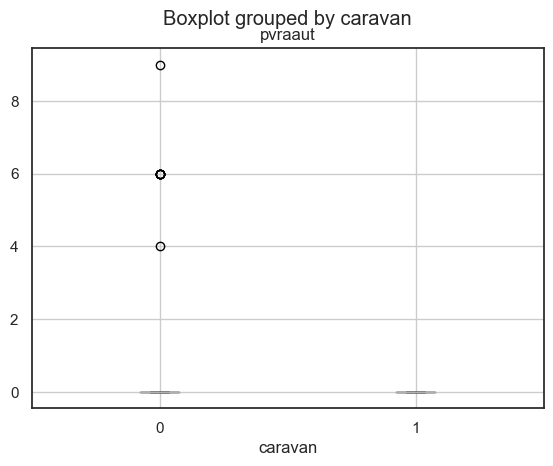

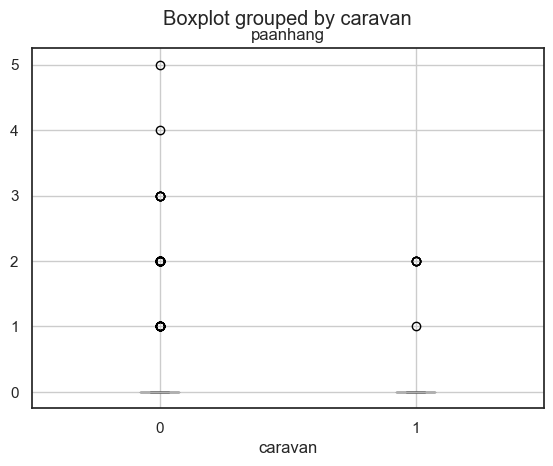

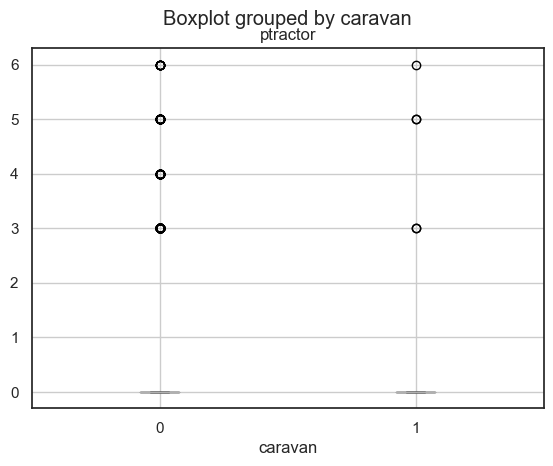

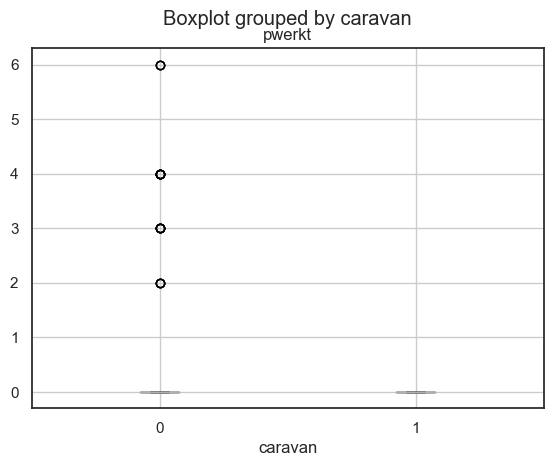

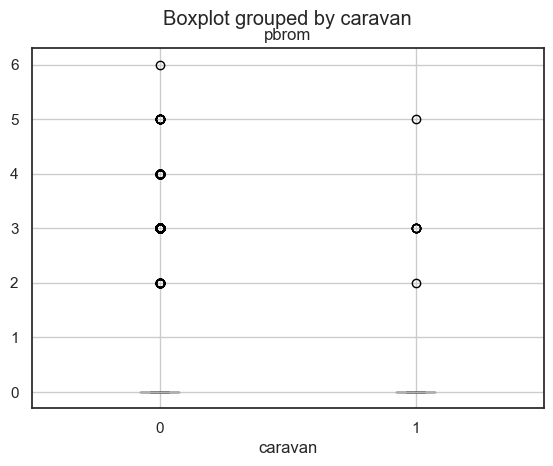

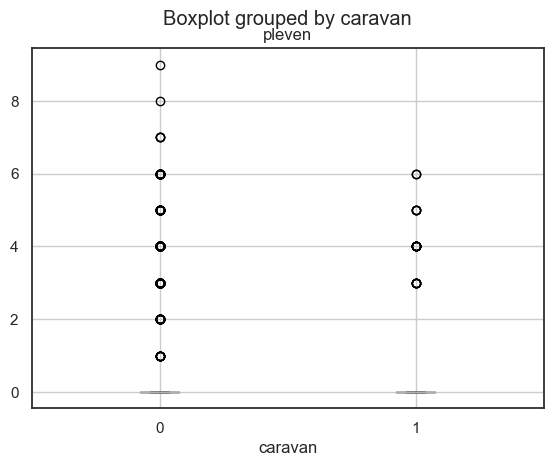

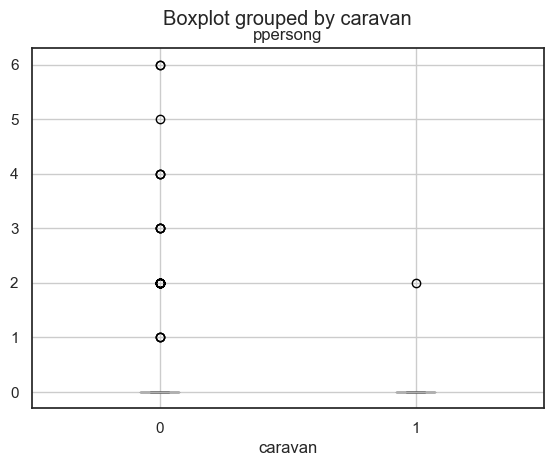

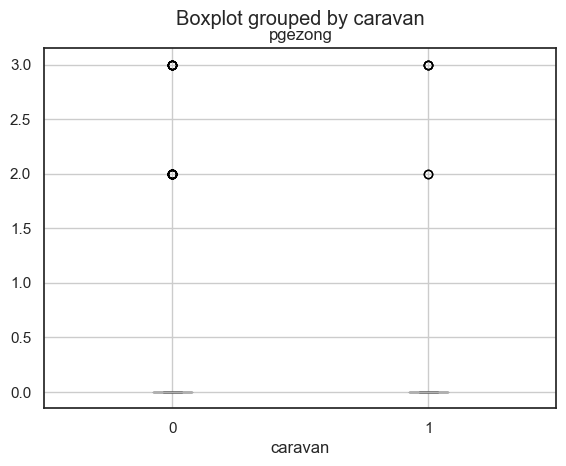

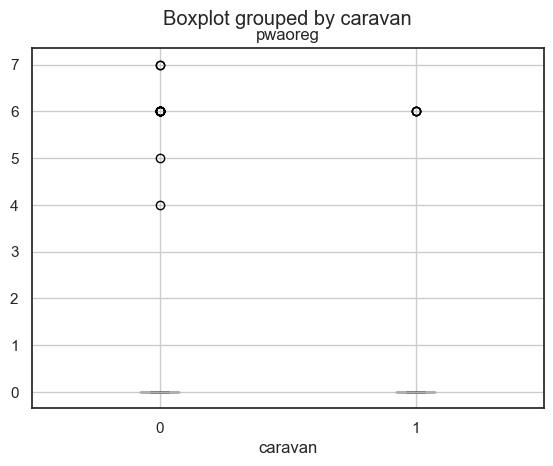

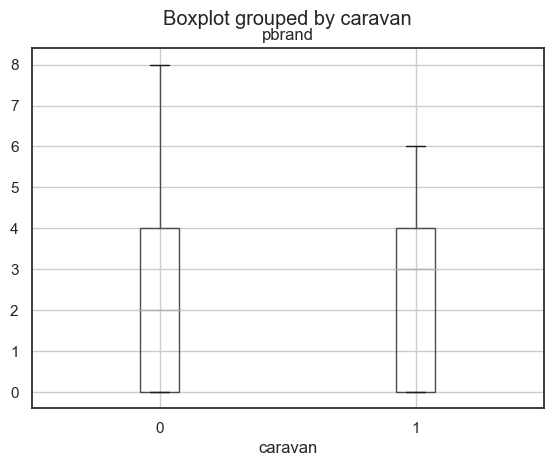

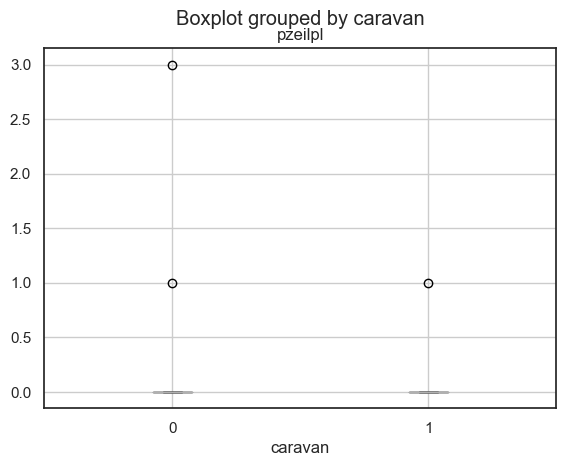

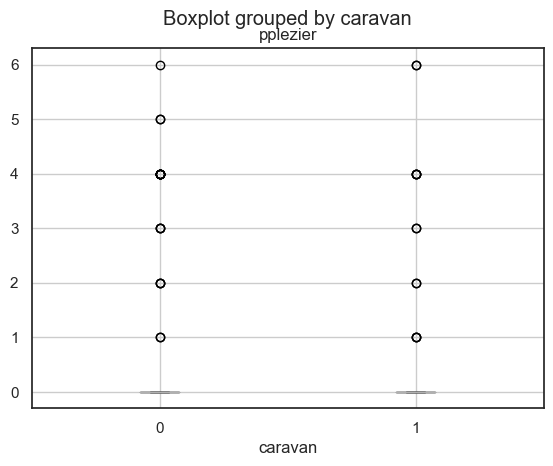

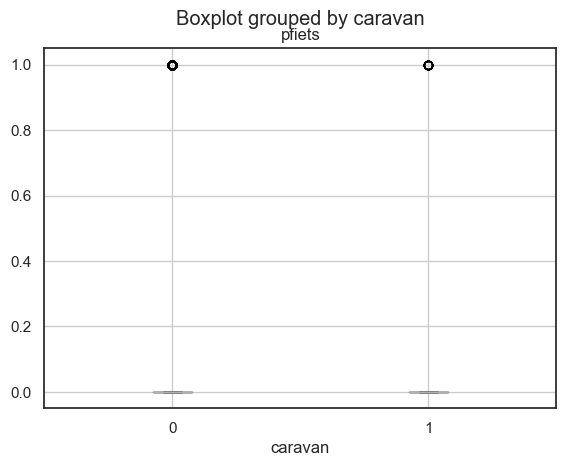

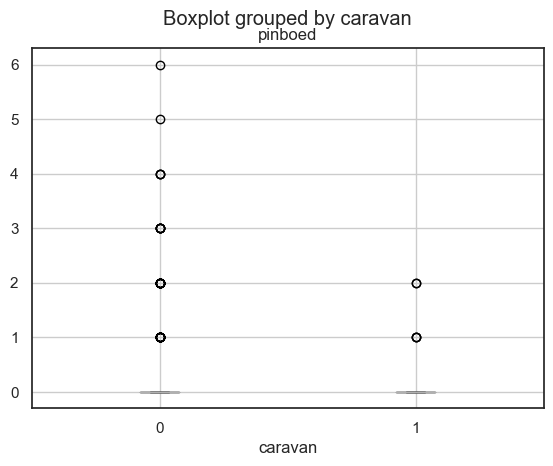

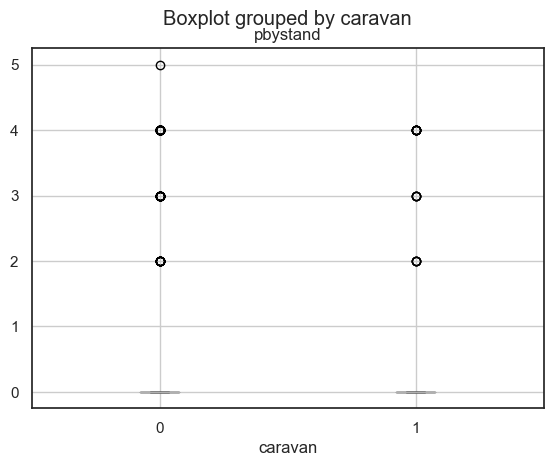

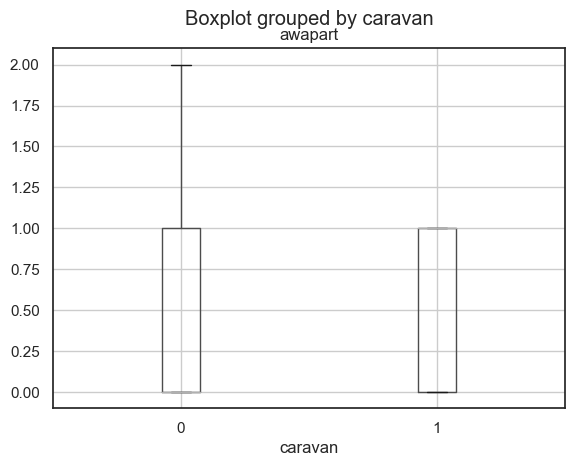

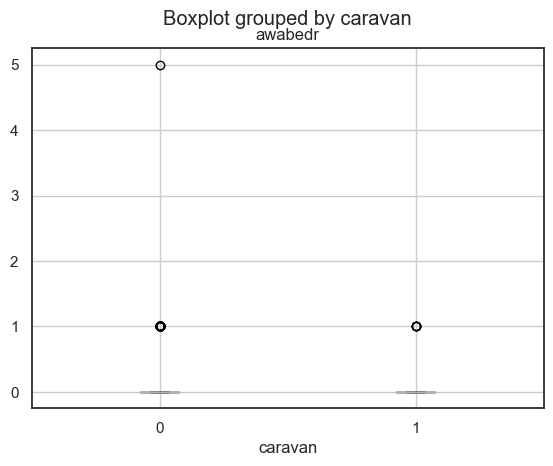

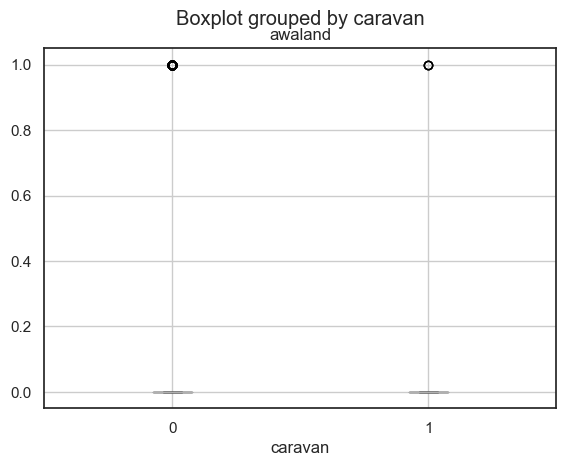

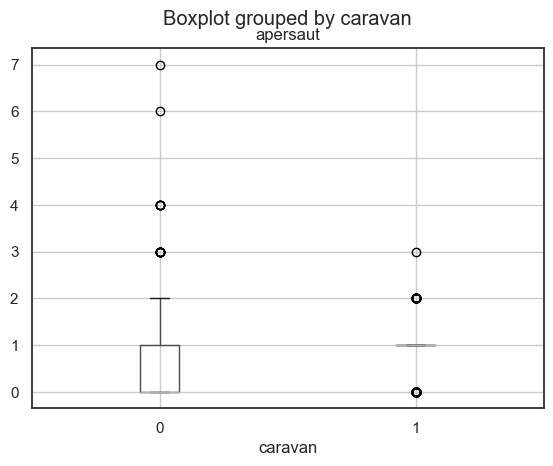

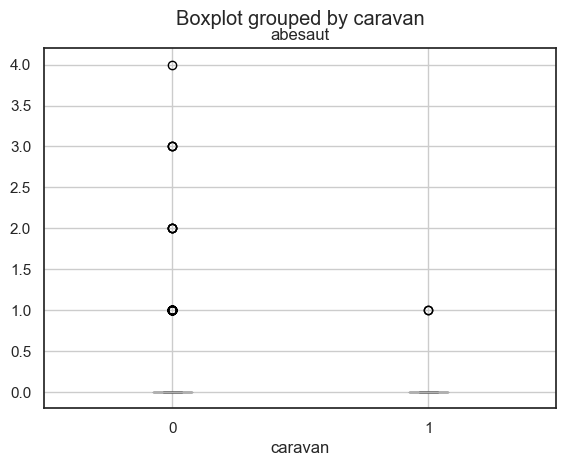

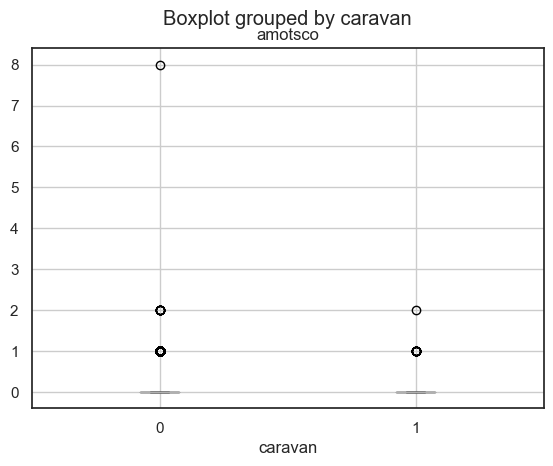

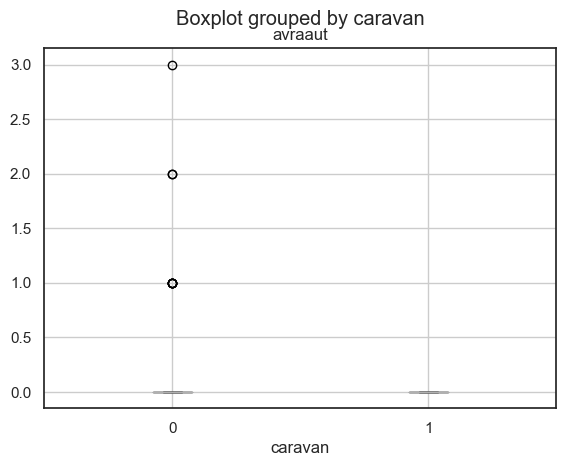

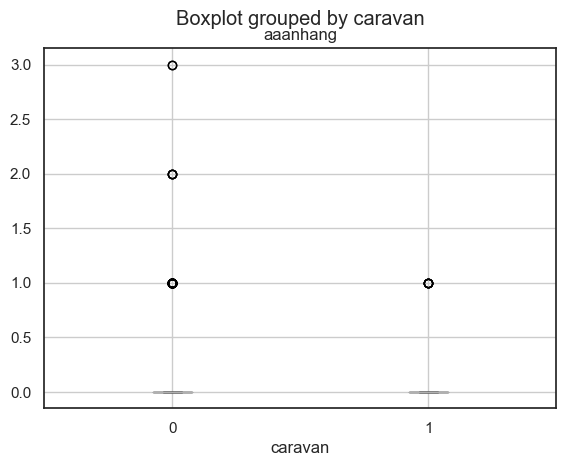

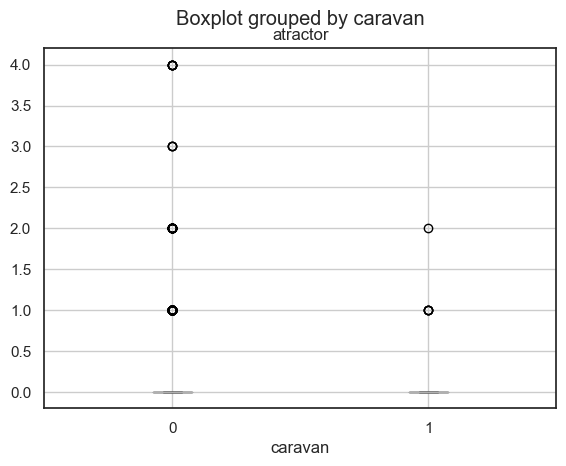

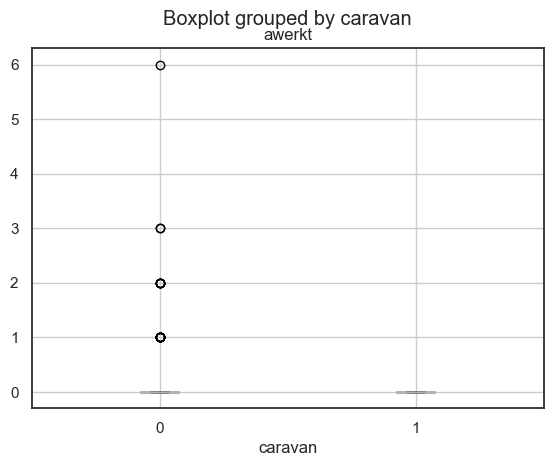

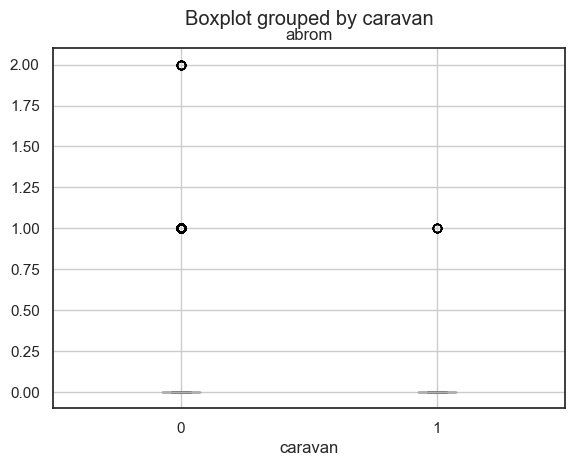

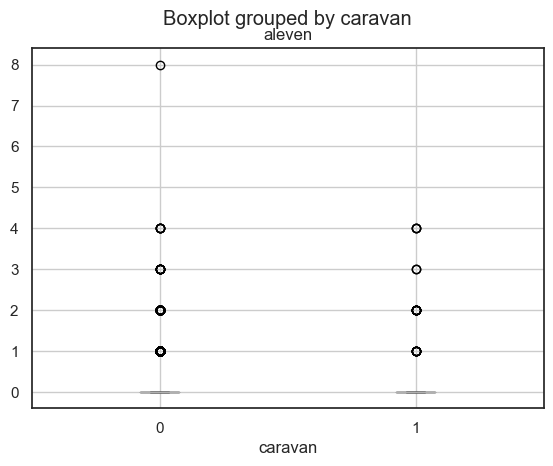

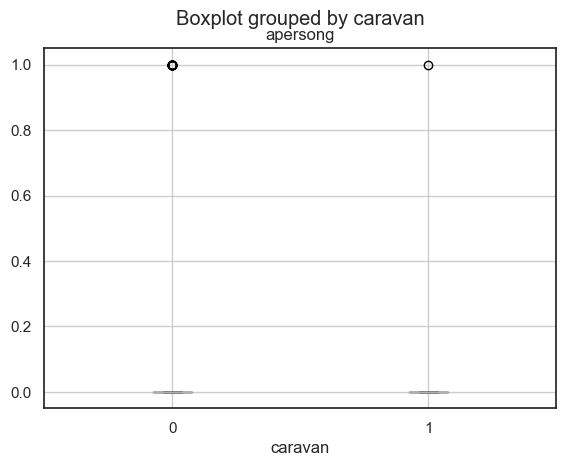

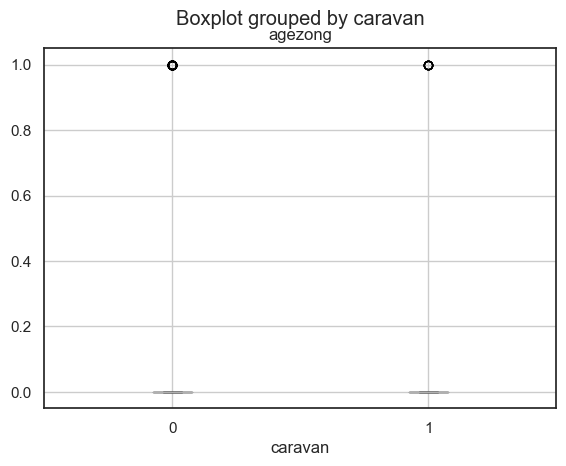

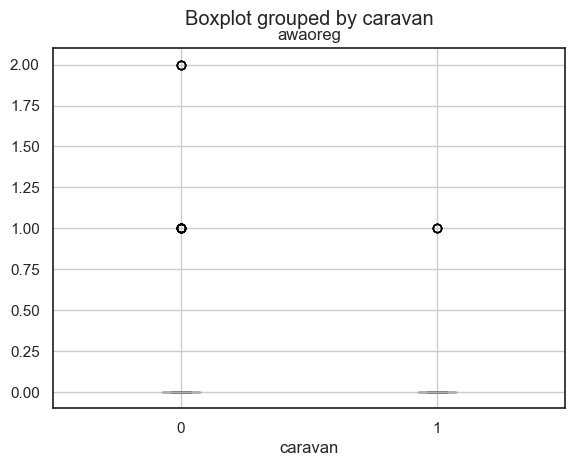

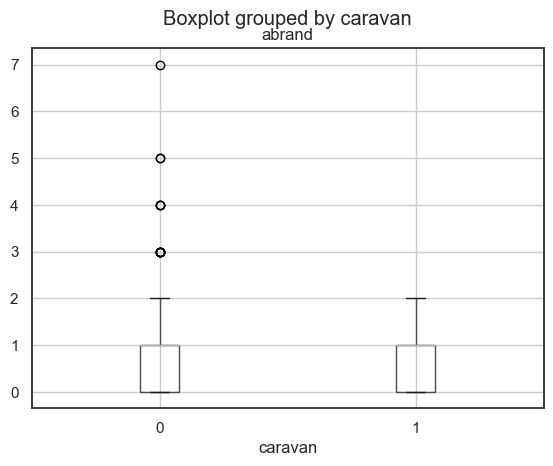

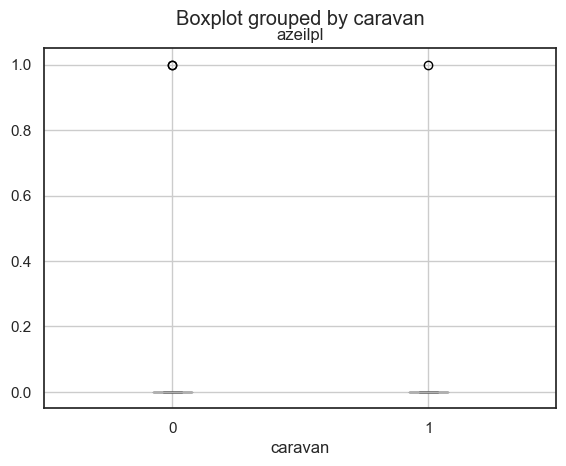

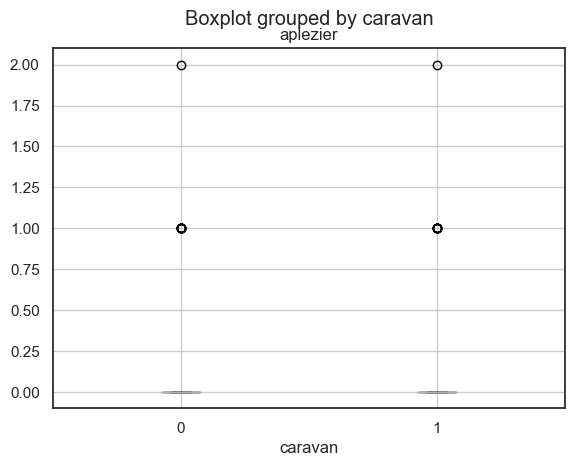

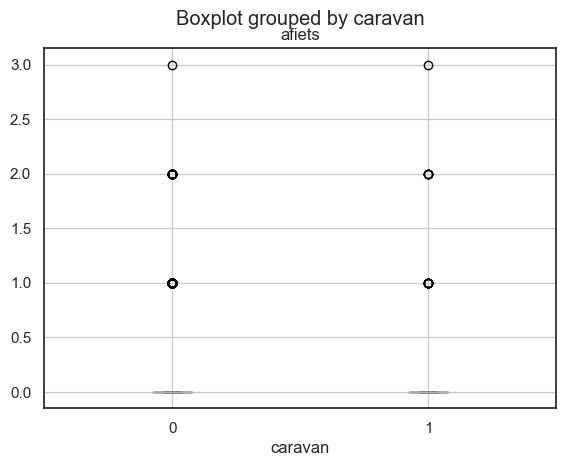

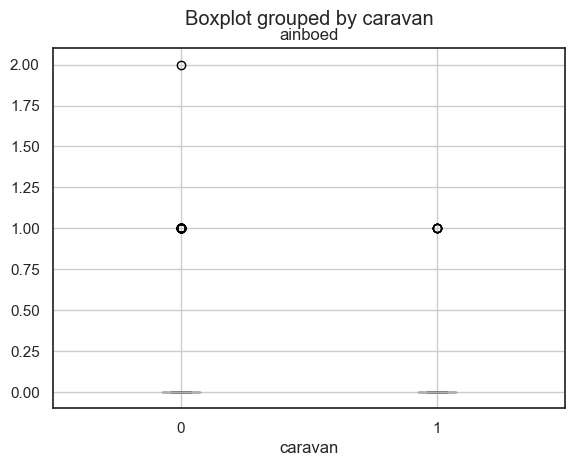

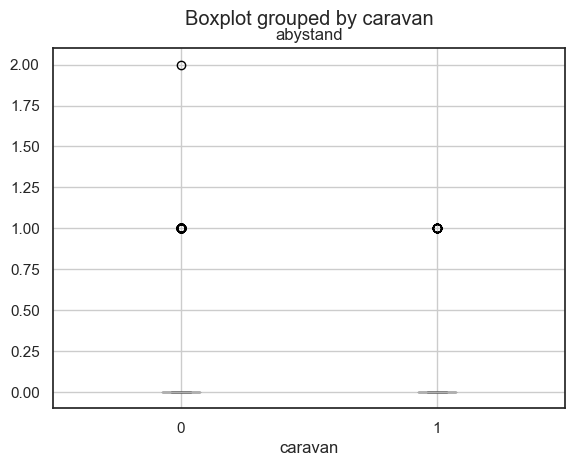

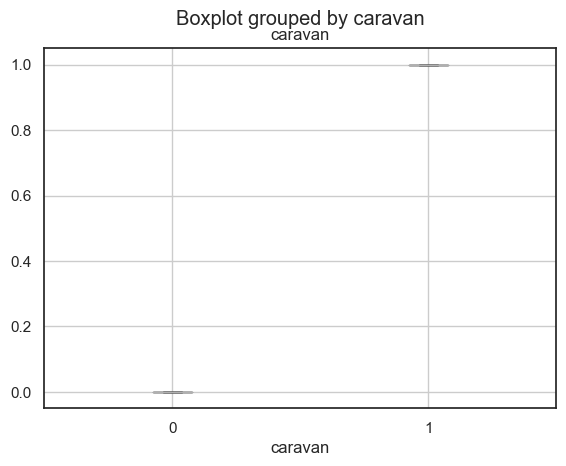

In [16]:
warnings.filterwarnings('ignore')
for i in list(data.columns):
    data.boxplot(column=i, by='caravan')

En los boxplots creados, se pueden observar outliers en la mayoría de las variables. A pesar de esto, decidimos mantenerlas en el análisis ya que los creemos necesarios para en el análisis ya que existe la posibilidades de que haya nuevos clientes con estos mismos valores.